In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib as mpl
    
import sys  
sys.path.insert(0, '../src/')
from jsm_routines import SHMF, CSMF, SHMR, scatter_stat, CSMF_1D
import galhalo


>>> Normalizing primordial power spectrum P(k)=(k/k_0)^n_s ...
    such that sigma(R=8Mpc/h) =   0.8000.
>>> Tabulating sigma(M,z=0) ...
    From now on, sigma(M,z) is computed by interpolation.
>>> Tabulating z(W) and z(t_lkbk)...
>>> Preparing output redshifts for merger trees ...
    Number of output redshifts =  354, up to z = 20.06
>>> Tabulating Parkinson+08 J(u_res) ...
>>> Building interpolation grid for Green+19 M(<r|f_b,c)...
>>> Building interpolation grid for Green+19 sigma(r|f_b,c)...
>>> Building interpolation grid for Green+19 d2Phidr2(r|f_b,c)...
>>> Building interpolator for Jiang+15 orbit sampler...


### reading in the accreation masses and redshifts for the surviving halos

In [4]:
Mh = np.load("../../acc_surv_mass.npy")

In [5]:
#so you can see the dimensionality, I have printed the shapes of the two matrices

print("( N realizations x N subhalos )")

print(Mh.shape) # where there are 3129 MT realizations and 1650 potential subhalo slots for each realization
# the same is true for the redshifts

( N realizations x N subhalos )
(3129, 1650)


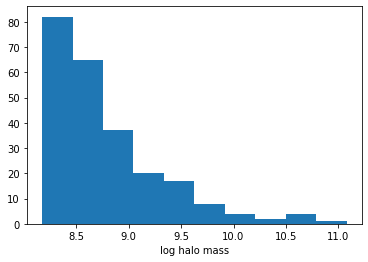

In [6]:
# so you can see the subhalo masses in a single MT realization (in this case the 320th)
mass_ex = Mh[320]

mass_ex[0] = 0.0  # removing the host mass from the matrix
zero_mask = mass_ex != 0.0 
mass_ex = np.log10(np.where(zero_mask, mass_ex, np.nan)) #switching the to nans so the plotting doesnt complain

plt.hist(mass_ex)
plt.xlabel("log halo mass")
plt.show()

### now converting to stellar mass

In [7]:
Ms = SHMR(Mh) # now converting to stellar mass using the deterministic SHMR from Danielli et al 2022
# this step removes does everyting in the previous cell (removes host mass, switches to nans and takes the log)
# the conversion formula is below

$\log_{10} (M_{*}) = \log_{10} (\epsilon M_{1})+ \alpha \log_{10} (M_{peak}) - \alpha \log_{10}(M_1)$

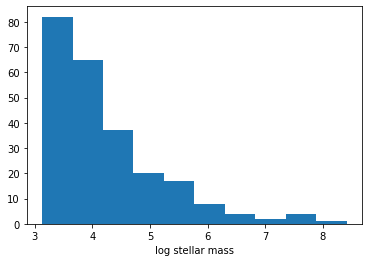

In [8]:
# now for the same MT realization we can plot the stellat mass distribution 
plt.hist(Ms[320])
plt.xlabel("log stellar mass")
plt.show()

### now measuring (N > $M_*$)

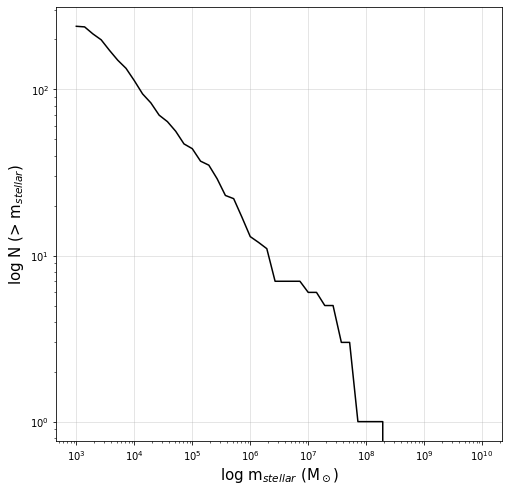

In [9]:
# to break this down, I made the same CSMF but instead of operating on a mass matrix (several MT realizations) it operates on a single array (1 MT realization)
# again taking our favorite 320th realization we see what the CSMF looks like...

hmm = CSMF_1D(Ms[320])

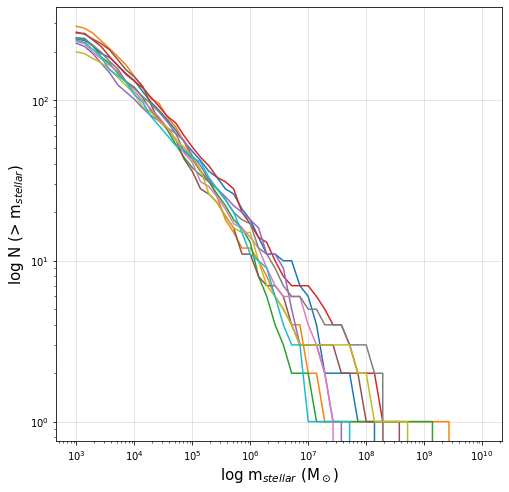

In [10]:
# or we can see what the first 10 look like

test = []
for i in range(10):

    M = Mh[i]
    M[0] = 0.0  # removing the host mass from the matrix
    zero_mask = M != 0.0 
    M = np.log10(np.where(zero_mask, M, np.nan)) #switching the to nans!

    test.append(CSMF_1D(galhalo.lgMs_D22_det(M), plot=False))

mass_range = np.logspace(3,10,50)

plt.figure(figsize=(8, 8))

for i in test:
    plt.plot(mass_range, i)

plt.grid(alpha=0.4)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("log m$_{stellar}$ (M$_\odot$)", fontsize=15)
plt.ylabel("log N (> m$_{stellar}$)", fontsize=15)
plt.show()

### now for all 3129 realizations

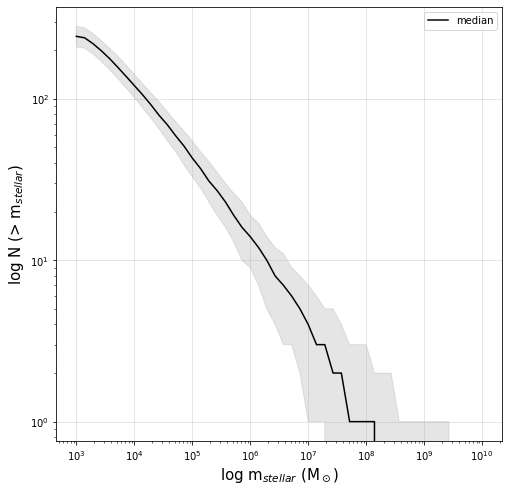

( N realizations x N mass pixels )
(3129, 50)


In [11]:
CSMF_mat = CSMF(Ms, full=True) #this returns the counts in the CSMF as a matrix

print("( N realizations x N mass pixels )")
print(CSMF_mat.shape)

In [12]:
# so you can see some of the values in each mass pixel
print(CSMF_mat)

[[243. 241. 217. ...   0.   0.   0.]
 [287. 279. 260. ...   0.   0.   0.]
 [239. 234. 217. ...   0.   0.   0.]
 ...
 [230. 227. 209. ...   0.   0.   0.]
 [237. 231. 222. ...   0.   0.   0.]
 [248. 240. 223. ...   0.   0.   0.]]


### now measuring the percentiles

In [13]:
# I can rank order them using a numpy routine
test = np.sort(CSMF_mat, axis=0)

print(test)

# and manually grab the 5%, 50% and 95% for each mass bin

ind_5 = int(0.05*CSMF_mat.shape[0])
ind_50 = int(0.5*CSMF_mat.shape[0])
ind_95 = int(0.95*CSMF_mat.shape[0])

[[168. 164. 154. ...   0.   0.   0.]
 [171. 166. 155. ...   0.   0.   0.]
 [183. 179. 163. ...   0.   0.   0.]
 ...
 [324. 315. 291. ...   1.   0.   0.]
 [326. 315. 293. ...   1.   0.   0.]
 [341. 328. 302. ...   1.   0.   0.]]


In [14]:
low = test[ind_5,:]
print(low)

median = test[ind_50,:]
print(median)

high = test[ind_95,:]
print(high)

# where this is a 3 x 50 matrix

print("( N percentiles x N mass bins )")


[210. 206. 190. 171. 152. 134. 117. 102.  88.  76.  65.  55.  47.  39.
  33.  28.  23.  19.  16.  13.  10.   9.   7.   5.   4.   3.   3.   2.
   1.   1.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.]
[244. 239. 220. 199. 178. 157. 138. 121. 106.  92.  79.  69.  59.  51.
  43.  37.  31.  27.  23.  19.  16.  14.  12.  10.   8.   7.   6.   5.
   4.   3.   3.   2.   2.   1.   1.   1.   1.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.]
[282. 275. 254. 230. 206. 184. 162. 142. 124. 109.  96.  83.  72.  63.
  55.  47.  41.  35.  30.  26.  23.  19.  17.  14.  12.  11.   9.   8.
   7.   6.   5.   5.   4.   3.   3.   3.   2.   2.   2.   1.   1.   1.
   1.   1.   1.   1.   0.   0.   0.   0.]
( N percentiles x N mass bins )


### now to add scatter to the SHMR

In [15]:
#using the random normal generator from numpy I can create random samples defined by the sigma or dex value of my choice

sampling_25 = np.random.normal(loc=7, scale=0.25, size=1000) # for a 10^7 subhalo mass
sampling_50 = np.random.normal(loc=7, scale=0.5, size=1000) # for a 10^7 subhalo mass
sampling_100 = np.random.normal(loc=7, scale=1, size=1000) # for a 10^7 subhalo mass


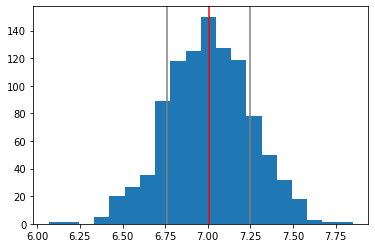

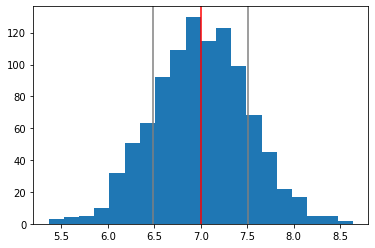

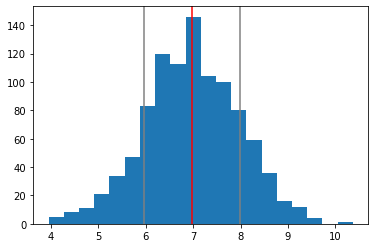

In [16]:

plt.hist(sampling_25, bins=20)
plt.axvline(np.mean(sampling_25), color="red")
plt.axvline(np.mean(sampling_25)-np.std(sampling_25), color="grey")
plt.axvline(np.mean(sampling_25)+np.std(sampling_25), color="grey")
plt.show()

plt.hist(sampling_50, bins=20)
plt.axvline(np.mean(sampling_50), color="red")
plt.axvline(np.mean(sampling_50)-np.std(sampling_50), color="grey")
plt.axvline(np.mean(sampling_50)+np.std(sampling_50), color="grey")
plt.show()

plt.hist(sampling_100, bins=20)
plt.axvline(np.mean(sampling_100), color="red")
plt.axvline(np.mean(sampling_100)-np.std(sampling_100), color="grey")
plt.axvline(np.mean(sampling_100)+np.std(sampling_100), color="grey")
plt.show()


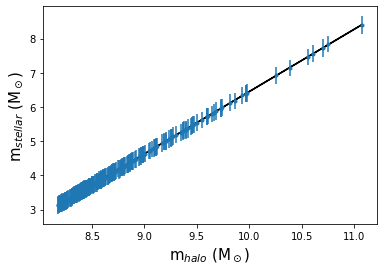

In [17]:
# now just as an illustration, I randomly sampled the 320 MT realization 500 times and took the average and std

Mh_clean = np.log10(Mh[320][~np.isnan(Ms[320])])
Ms_clean = Ms[320][~np.isnan(Ms[320])]

rand = np.array([np.random.normal(loc=i, scale=0.25, size=500) for i in Ms_clean]) # this loops over the subhalos!

ave = np.nanmean(rand, axis=1)
std = np.nanstd(rand, axis=1)

plt.plot(Mh_clean, Ms_clean, color="black")
plt.errorbar(Mh_clean, ave, yerr=std, ls="None", marker=".")
plt.ylabel("m$_{stellar}$ (M$_\odot$)", fontsize=15)
plt.xlabel("m$_{halo}$ (M$_\odot$)", fontsize=15)
plt.show()


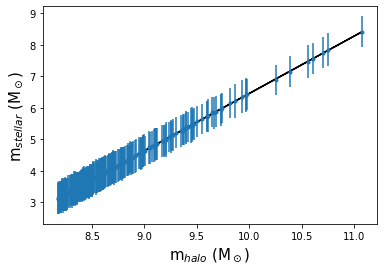

In [18]:
Mh_clean = np.log10(Mh[320][~np.isnan(Ms[320])])
Ms_clean = Ms[320][~np.isnan(Ms[320])]

rand = np.array([np.random.normal(loc=i, scale=0.5, size=500) for i in Ms_clean])

ave = np.nanmean(rand, axis=1)
std = np.nanstd(rand, axis=1)

plt.plot(Mh_clean, Ms_clean, color="black")
plt.errorbar(Mh_clean, ave, yerr=std, ls="None", marker=".")
plt.ylabel("m$_{stellar}$ (M$_\odot$)", fontsize=15)
plt.xlabel("m$_{halo}$ (M$_\odot$)", fontsize=15)
plt.show()

In [19]:
# now choping off the excess nan values

max_real = max(Ms.shape[1] - np.sum(np.isnan(Ms),axis=1))

Ms = Ms[:,1:max_real]

In [22]:
Ms.shape

(3129, 340)

In [23]:
# now to loop over each value of scatter, now to loop for every realization, and every subhalo!

scatter_pix = 15
scatter_range = np.round(np.linspace(0.1,0.5,scatter_pix), 3)
N_samples=500

mat = np.zeros(shape=(scatter_pix,Ms.shape[0],Ms.shape[1],N_samples))

for k, sigma in enumerate(scatter_range):

    print(k)

    for i, pop in enumerate(Ms):

        for j, subhalo in enumerate(pop):

            mat[k, i, j] = np.random.normal(loc=subhalo, scale=sigma, size=N_samples)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [21]:
#np.save("../figures/4D.npy", mat) # saving the data so I don't need to rerun it!

#mat = np.load("../figures/4D.npy")

FileNotFoundError: [Errno 2] No such file or directory: '../figures/4D.npy'

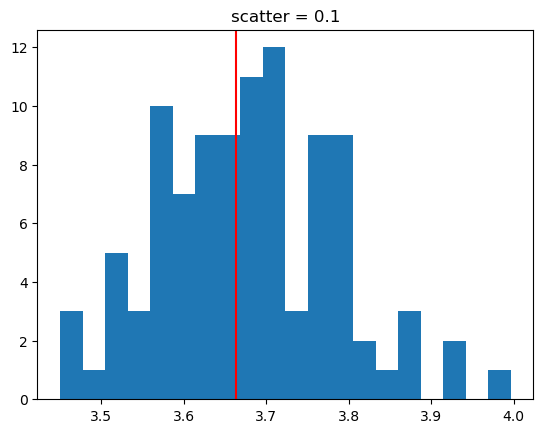

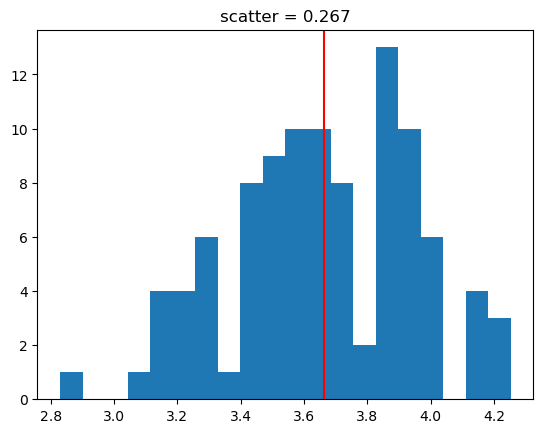

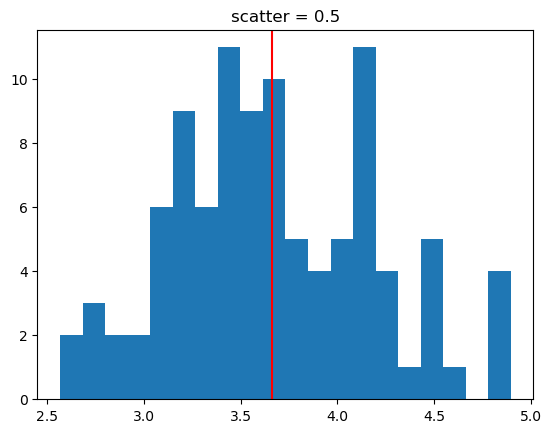

In [ ]:
# # now again as an example of the random sampling I am doing for each subhalo

# plt.hist(mat[0,320,52],bins=20)
# plt.title("scatter = "+str(scatter_range[0]))
# plt.axvline(Ms[320,52], color="red")
# plt.show()

# plt.hist(mat[10,320,52],bins=20)
# plt.title("scatter = "+str(scatter_range[10]))
# plt.axvline(Ms[320,52], color="red")
# plt.show()

# plt.hist(mat[24,320,52],bins=20)
# plt.title("scatter = "+str(scatter_range[24]))
# plt.axvline(Ms[320,52], color="red")
# plt.show()

In [ ]:
new_mat = np.zeros(shape=(scatter_pix,N_samples,3,50))

for k in range(scatter_pix):

    print(k)
    
    for n in range(N_samples):

        new_mat[k,n] = CSMF(mat[k,:,:,n], plot=False)

In [ ]:
#np.save("../figures/4D_CSMF.npy", new_mat) # saving the data so I don't need to rerun it!

#new_mat = np.load("../figures/4D_CSMF.npy")

In [ ]:
across_samp = np.average(new_mat, axis=1) # now lets look at the values!!

### now for the CSMF colored by scatter in the SHMR

In [ ]:
norm = mpl.colors.Normalize(vmin=scatter_range.min(), vmax=scatter_range.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.viridis_r)

colors = mpl.cm.viridis_r(np.linspace(0, 1, scatter_pix))

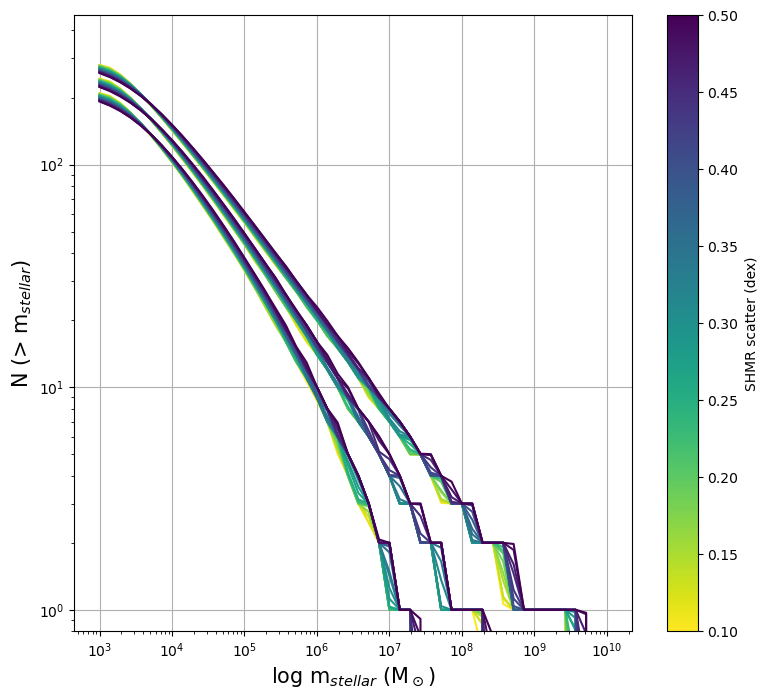

In [ ]:
plt.figure(figsize=(9, 8)) # now plotting the color-coded CSMF!!

for i in range(scatter_pix):
    plt.plot(mass_range, across_samp[i][2], color=colors[i])
    plt.plot(mass_range, across_samp[i][1], color=colors[i])
    plt.plot(mass_range, across_samp[i][0], color=colors[i])


plt.yscale("log")
plt.xscale("log")
plt.grid()
plt.colorbar(cmap, label="SHMR scatter (dex)")
plt.xlabel("log m$_{stellar}$ (M$_\odot$)", fontsize=15)
plt.ylabel("N (> m$_{stellar}$)", fontsize=15)
plt.ylim(0.8)
plt.show()

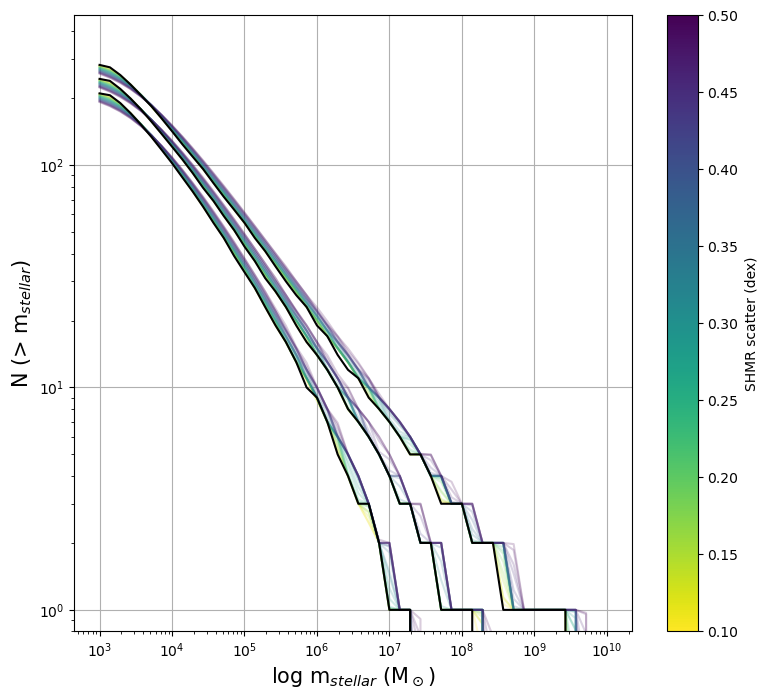

In [ ]:
plt.figure(figsize=(9, 8)) # now plotting the color-coded CSMF!!

for i in range(scatter_pix):
    plt.plot(mass_range, across_samp[i][2], color=colors[i],alpha=0.2)
    plt.plot(mass_range, across_samp[i][1], color=colors[i],alpha=0.2)
    plt.plot(mass_range, across_samp[i][0], color=colors[i],alpha=0.2)

plt.plot(mass_range, low, color="black")
plt.plot(mass_range, median, color="black")
plt.plot(mass_range, high, color="black")


plt.yscale("log")
plt.xscale("log")
plt.grid()
plt.colorbar(cmap, label="SHMR scatter (dex)")
plt.xlabel("log m$_{stellar}$ (M$_\odot$)", fontsize=15)
plt.ylabel("N (> m$_{stellar}$)", fontsize=15)
plt.ylim(0.8)
plt.show()

### now for the final figure!

In [ ]:
stat_scatter = across_samp[:,2,:] - across_samp[:,0,:] # now only grabbing the mass bins I care about
median_scatter = across_samp[:,1,:]

mass_ind = [8,15,22,29,35]
masses = np.round(np.log10(mass_range[mass_ind]))


In [ ]:
stat_det = []
stat_scatter_select = []
median_det = []
median_scatter_select = []


for i in mass_ind:
    stat_det.append((high-low)[i])
    stat_scatter_select.append(stat_scatter[:,i])
    median_det.append(median[i])
    median_scatter_select.append(median_scatter[:,i])

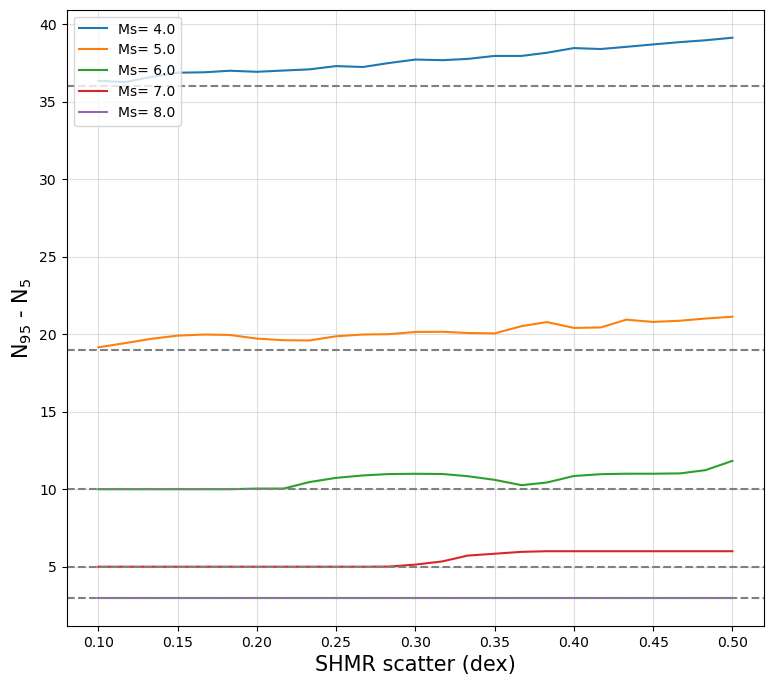

In [ ]:
plt.figure(figsize=(9,8))

for i in range(5):
    plt.plot(scatter_range, stat_scatter_select[i], label="Ms= "+str(masses[i]))
    plt.axhline(stat_det[i], ls="--", color="grey")

 
plt.xlabel("SHMR scatter (dex)", fontsize=15)
plt.ylabel("$\mathrm{N}_{95}$ - $\mathrm{N}_{5}$", fontsize=15)
plt.grid(alpha=0.4)
plt.legend(loc=2)
plt.show()

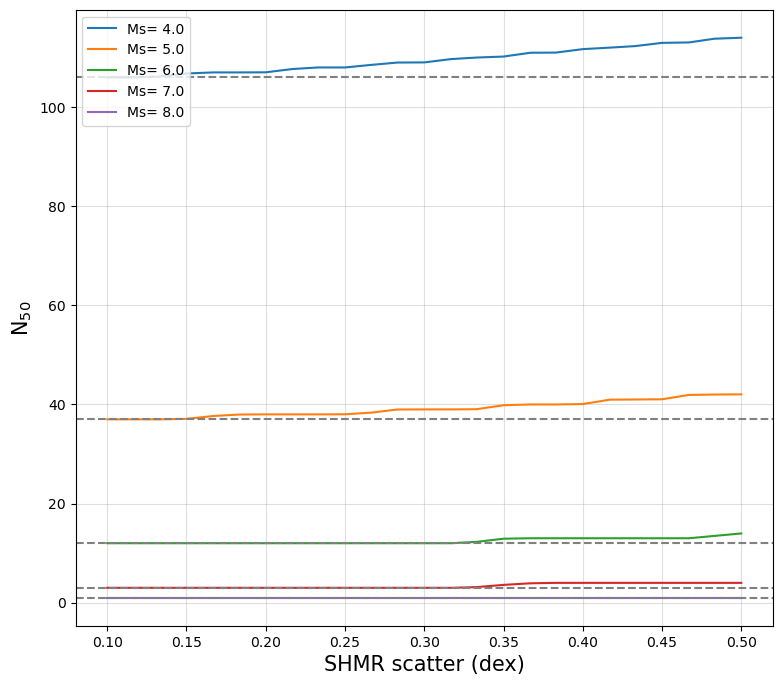

In [ ]:
plt.figure(figsize=(9,8))

for i in range(5):
    plt.plot(scatter_range, median_scatter_select[i], label="Ms= "+str(masses[i]))
    plt.axhline(median_det[i], ls="--", color="grey")

 
plt.xlabel("SHMR scatter (dex)", fontsize=15)
plt.ylabel("$\mathrm{N}_{50}$", fontsize=15)
plt.grid(alpha=0.4)
plt.legend(loc=2)
plt.show()

### now for one merger tree

In [ ]:
MT = mat[:,320,:,:]

In [ ]:
MT.shape

(25, 340, 100)

In [ ]:
new_mat_1D = np.zeros(shape=(scatter_pix,N_samples,50))

for k in range(scatter_pix):
    for n in range(N_samples):
        new_mat_1D[k,n] = CSMF_1D(MT[k,:,n], plot=False)

In [ ]:
across_samp_1D = np.average(new_mat_1D,axis=1)

across_samp_1D.shape

(25, 50)

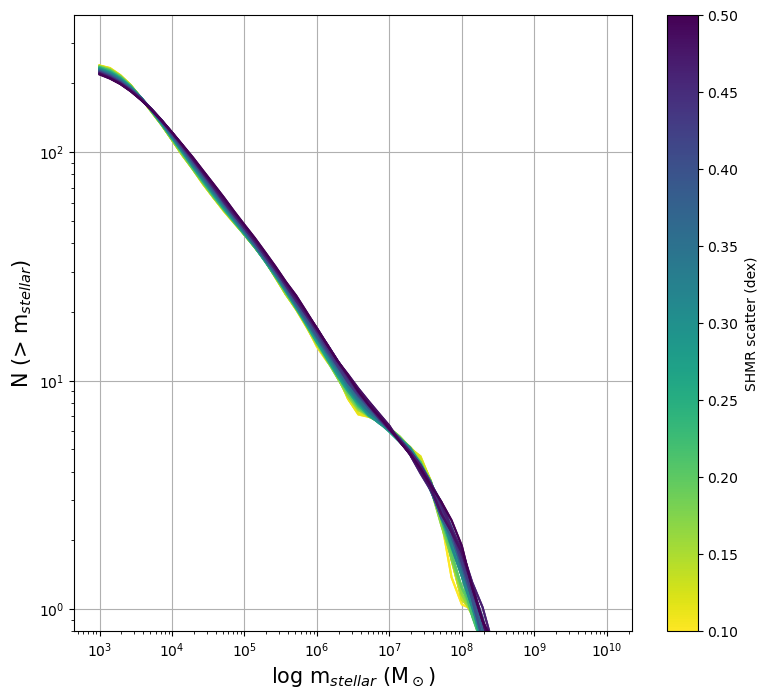

In [ ]:
plt.figure(figsize=(9, 8)) # now plotting the color-coded CSMF!!

for i in range(scatter_pix):
    plt.plot(mass_range, across_samp_1D[i], color=colors[i])
    plt.plot(mass_range, across_samp_1D[i], color=colors[i])

plt.yscale("log")
plt.xscale("log")
plt.grid()
plt.colorbar(cmap, label="SHMR scatter (dex)")
plt.xlabel("log m$_{stellar}$ (M$_\odot$)", fontsize=15)
plt.ylabel("N (> m$_{stellar}$)", fontsize=15)
plt.ylim(0.8)
plt.show()

In [ ]:
scatter_1D = []
det_1D = []
for i in mass_ind:
    scatter_1D.append(across_samp_1D[:,i])
    det_1D.append(hmm[i])

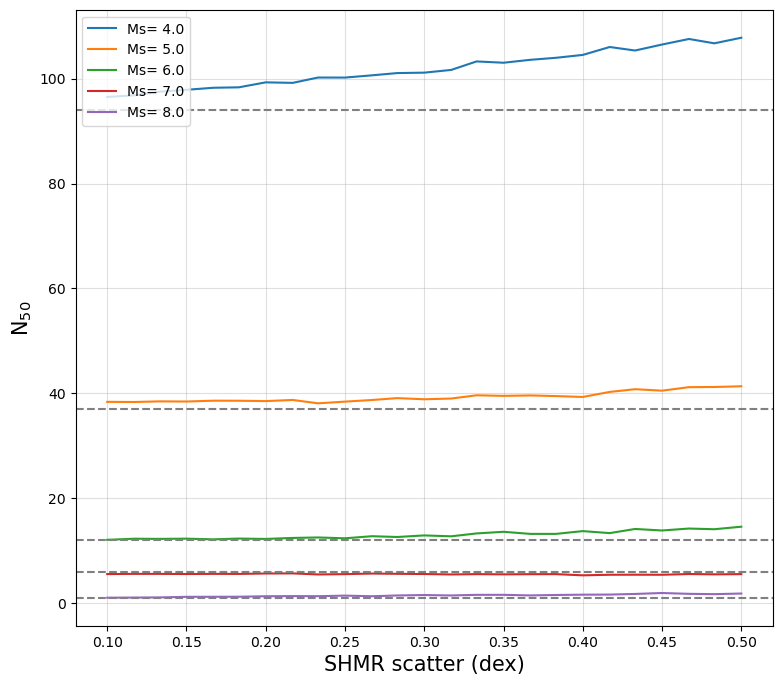

In [ ]:
plt.figure(figsize=(9,8))

for i in range(5):
    plt.plot(scatter_range, scatter_1D[i], label="Ms= "+str(masses[i]))
    plt.axhline(det_1D[i], ls="--", color="grey")

 
plt.xlabel("SHMR scatter (dex)", fontsize=15)
plt.ylabel("$\mathrm{N}_{50}$", fontsize=15)
plt.grid(alpha=0.4)
plt.legend(loc=2)
plt.show()